In [1]:
import logging
import os.path
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
import sinn.analyze.heatmap as heatmap
import sinn.optimize.gradient_descent as gd

import main as main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
def plot_L(datalen_lst, filename, desc_str='L', title=""):
    ncols = 2 if len(datalen_lst) > 1 else 1
    nrows = int(np.ceil(len(datalen_lst) / 2))
    plt.figure(figsize=(5*ncols, 4*nrows))

    for i, T in enumerate(datalen_lst):
        plt.subplot(nrows,ncols,i+1)

        #plt.title("Likelihood, {}s data".format(T))
        plt.title(title.format(T))
        #filename = basedir + "fsgif_{}s_sin-input_likelihood_2.sir".format(T)
        logL_base = heatmap.HeatMap.from_raw(io.loadraw( filename.format(T) ))
        params = [None]*2
        for j in range(2):
            params[j] = getattr(spikemodel.params, logL_base.axes[j].name)
            if logL_base.axes[j].idx is not None:
                params[j] = params[j][logL_base.axes[j].idx]
        
        if desc_str == 'L':
            L = main.exploglikelihood(logL_base)
        elif desc_str == 'log L':
            L = logL_base - logL_base.max()
            L.set_ceil(0)
            L.set_floor(-100)
            L.zlabel = 'log $L$'
        else:
            raise ValueError("Unrecognized desc string '{}'".format(desc_str))
        anlz.plot(L)

        color = anlz.stylelib.color_schemes.cmaps[L.cmap].white
        plt.axvline(params[0], c=color)
        plt.axhline(params[1], c=color)

        plt.xlabel('$'+logL_base.axes[0].name+'$')
        plt.ylabel('$'+logL_base.axes[1].name+'$')

    plt.tight_layout()

In [5]:
basedir = os.path.expanduser('~/Recherche/data/mackelab/code/fsGIF/')
basedir = os.path.expanduser('~/Recherche/macke_lab/labnotes/plots/2017-07-05/')
basedir = os.path.expanduser('~/Recherche/data/mackelab/code/fsGIF/short_adap/spikes/')

In [6]:
#main.load_spikes(basedir + 'fsgif_10s_sin-input.sir')
#main.load_spikes(basedir + 'fsgif_sin-input_10s_314seed.sir')
main.load_spikes(basedir + 'fsgif_sin-input_10s_314seed')
spikemodel = main.loaded['spiking model']

2017-07-28 11:50:09,474 - root - INFO - Checking for precomputed data...


# Numpy likelihoods

## Original adaptation constant ($τ_a$ = 1 ms)

In [22]:
basedir = os.path.expanduser('~/Recherche/data/mackelab/code/fsGIF/normal_adap/')

In [7]:
filename_base = basedir + "fsgif_{}s_sin-input_likelihood"
for i, T in enumerate([2,4,6,8]):
    filename = filename_base.format(T)
    logL_base = io.load( filename + ".sin")
    io.saveraw( filename + ".sir", logL_base)

### Likelihood

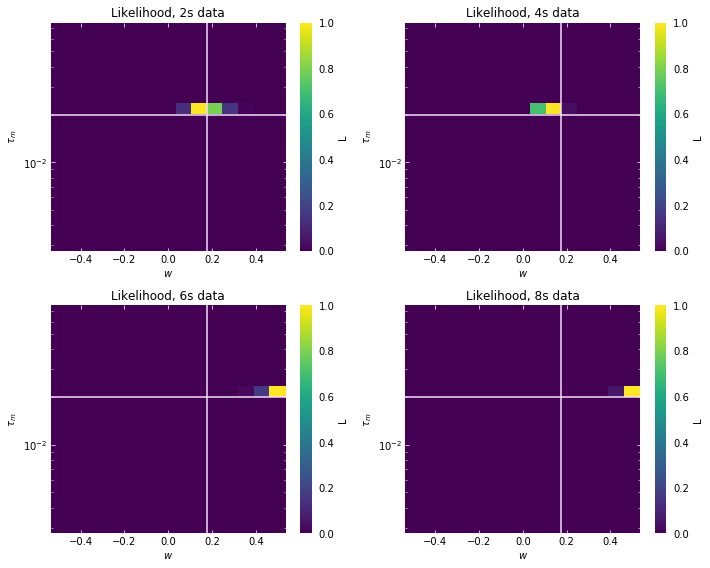

In [8]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood.sir",
       'L',
       "Likelihood, {}s data")

### Log likelihood

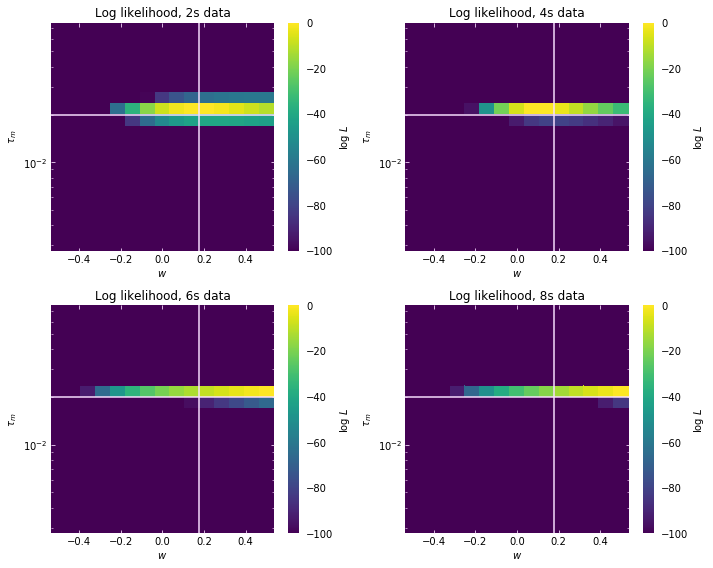

In [23]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood.sir",
       'log L',
       "Log likelihood, {}s data")

## Short adaptation constant ($τ_a$ = 0.2 ms)

### Likelihood

In [26]:
basedir = os.path.expanduser('~/Recherche/macke_lab/labnotes/plots/2017-07-05/')

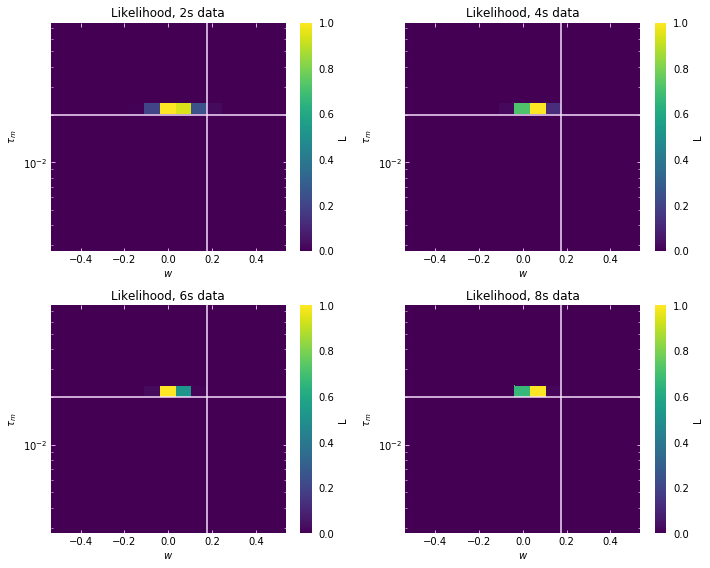

In [27]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood_2.sir",
       'L',
       "Likelihood, {}s data")

### Log likelihood

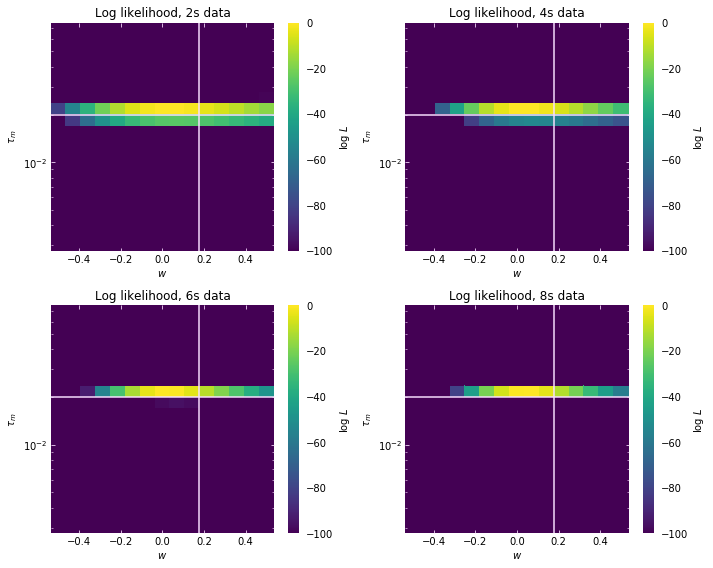

In [25]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood_2.sir",
       'log L',
       "Log likelihood, {}s data")

# Theano likelihoods
Calculating the likelihood with Theano is slower than with Numpy, so I limited runs to 2s and 4s data lengths.

## Short adaptation constant ($τ_a$ = 0.2 ms)

In [7]:
basedir = os.path.expanduser('~/Recherche/macke_lab/code/fsGIF/data/short_adap/likelihoods/')

### Likelihood

In [20]:
plot_datalens = {314: [2,4,6,8],
                 0: [2,4,6,8],
                 #100: [],
                 200: [2,4,6,8],
                 300: [2,6,8]}

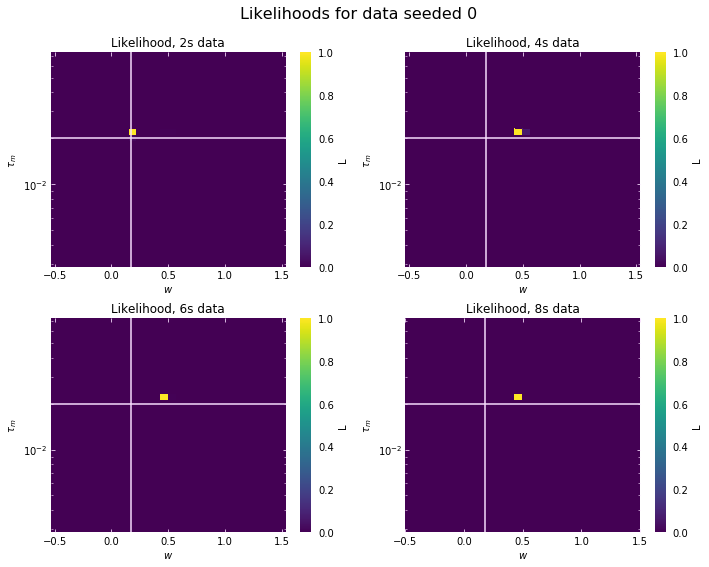

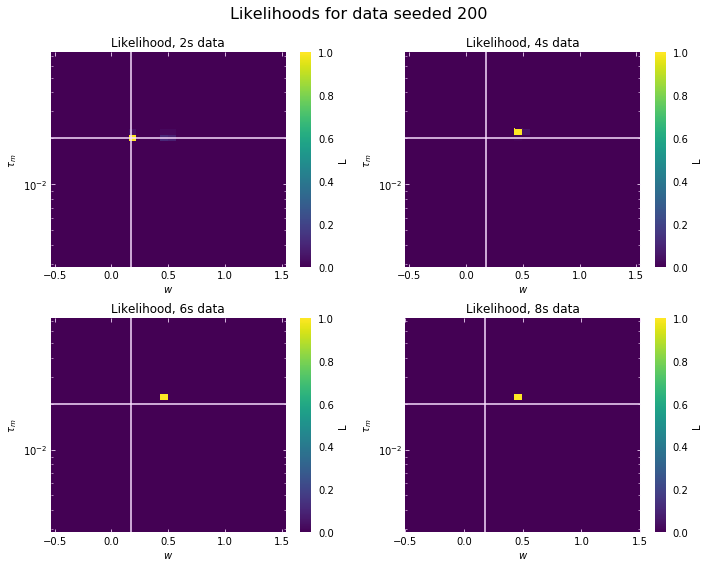

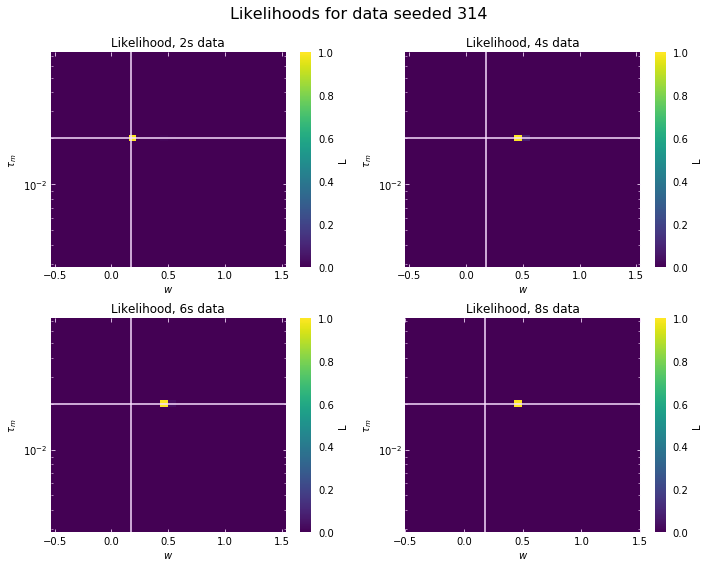

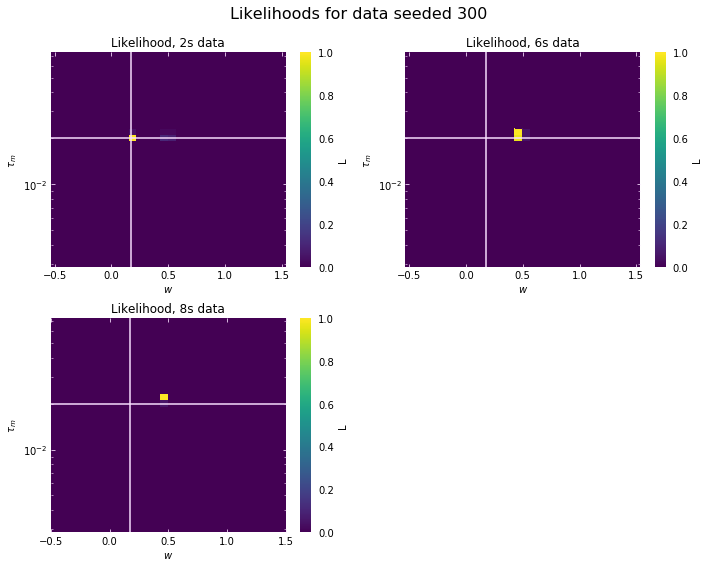

In [24]:
for seed, datalens in plot_datalens.items():
    plot_L(datalens,
           basedir + "fsgif_sin-input_{}s_" + str(seed) + "seed_loglikelihood_theano.sir",
           'L',
           "Likelihood, {}s data")
    plt.suptitle("Likelihoods for data seeded {}".format(seed), fontsize=16)
    plt.xlim((-0.5,1.5))
    plt.subplots_adjust(top=0.9)

### Log likelihood

In [11]:
filename = basedir + "fsgif_sin-input_10burnin_8s_314seed_loglikelihood_theano.sir"
logL = heatmap.HeatMap.from_raw(io.loadraw( filename ))

In [13]:
logL.axes[0].name

'w'

(<matplotlib.axes._subplots.AxesSubplot at 0x7f86f904cdd8>,
 <matplotlib.colorbar.Colorbar at 0x7f86f8f99e80>)

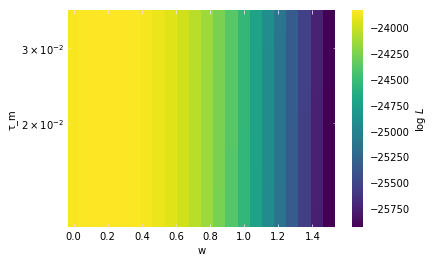

In [12]:
anlz.plot(logL)

In [16]:
logL.argmax()

(0.21428571428571427, 0.035000000000000003)

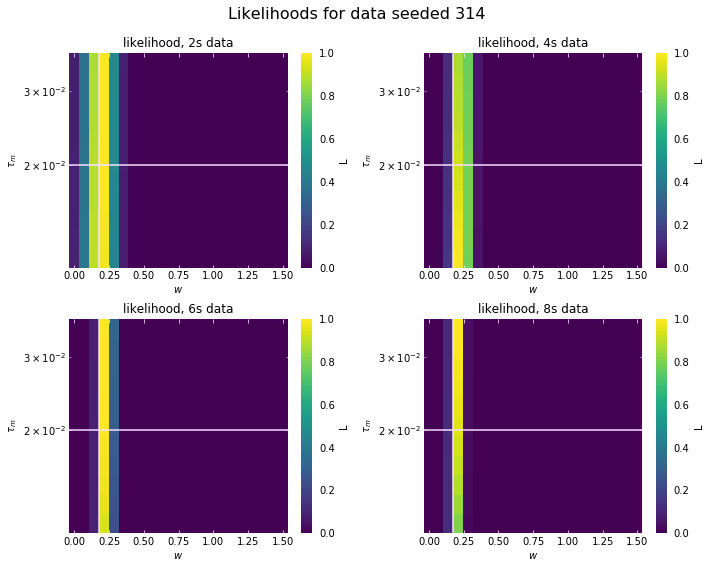

In [12]:
dlens = {314: [2,4,6,8]}
for seed, datalens in dlens.items():
    plot_L(datalens,
           basedir + "fsgif_sin-input_10burnin_{}s_" + str(seed) + "seed_loglikelihood_theano.sir",
           'L',
           "likelihood, {}s data")
    plt.suptitle("Likelihoods for data seeded {}".format(seed), fontsize=16)
   #plt.xlim((-0.5,1.5))
    plt.subplots_adjust(top=0.9)

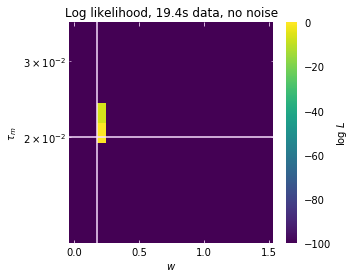

In [13]:
plot_L([19.4],
       basedir + "fsgif_no-input_0-5burnin_19-4s_" + str(314) + "seed_loglikelihood_theano.sir",
       'log L',
       "Log likelihood, {}s data, no noise")
#plt.suptitle("Log likelihoods for data seeded {}".format(seed), fontsize=16)
#plt.xlim((-0.5,1.5))
plt.subplots_adjust(top=0.9)

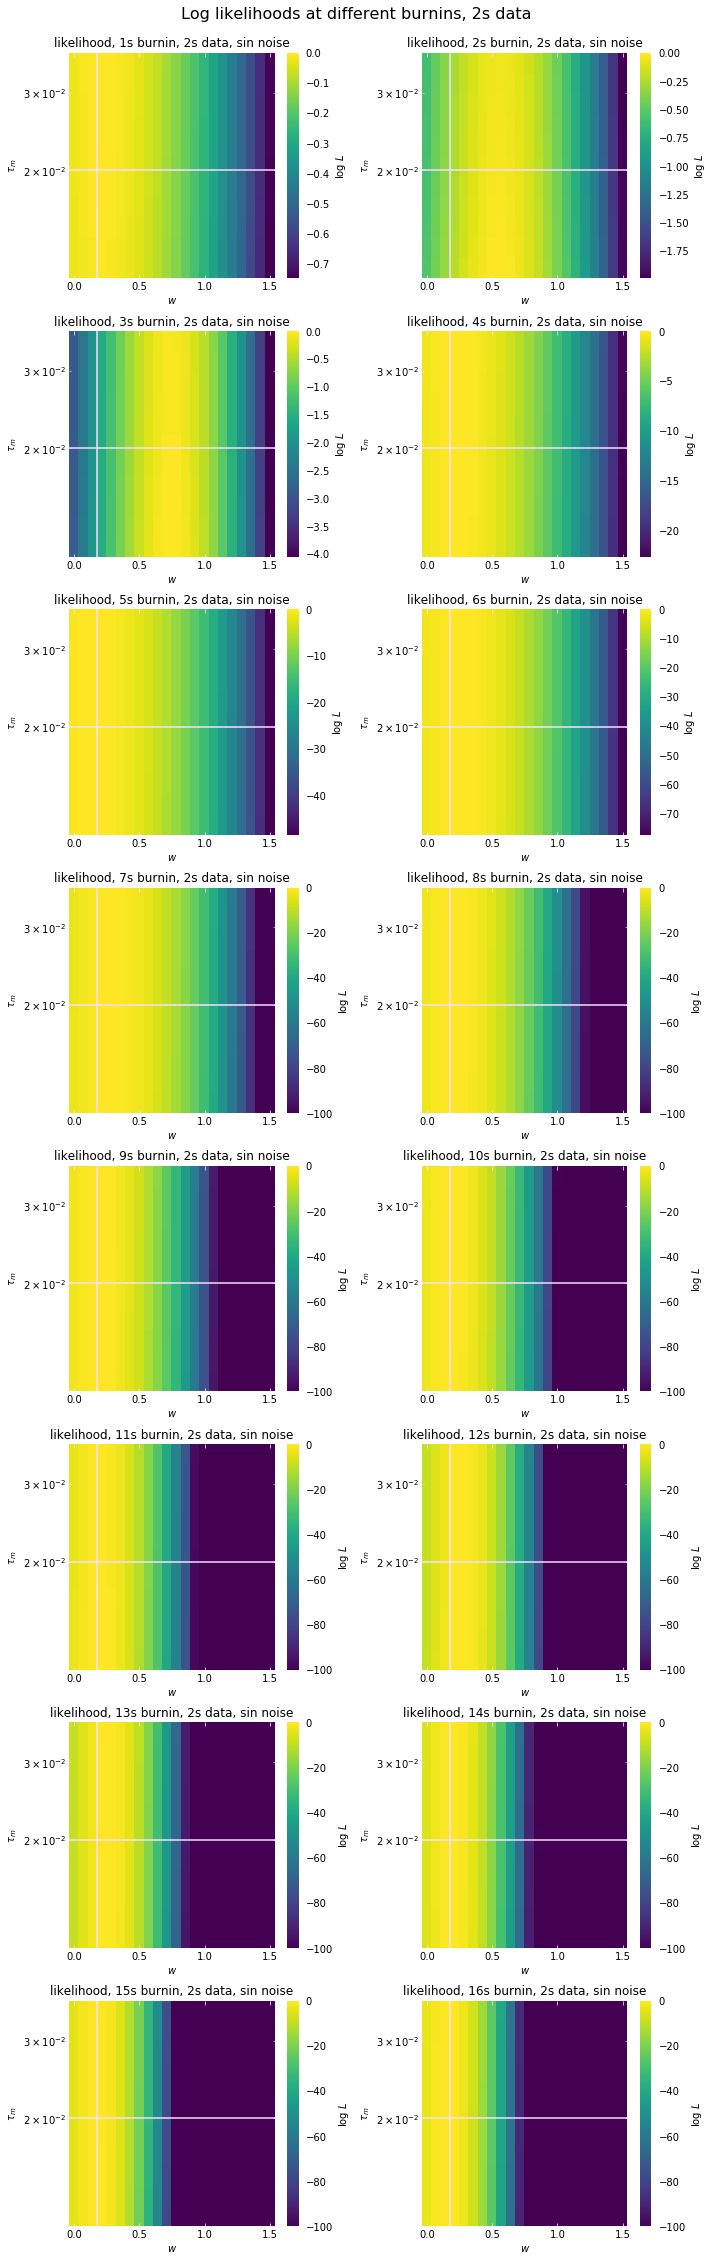

In [20]:
plot_L(range(1, 17),
       basedir + "fsgif_sin-input_{}burnin_2s_" + str(314) + "seed_loglikelihood_theano.sir",
       'log L',
       "likelihood, {}s burnin, 2s data, sin noise")
plt.suptitle("Log likelihoods at different burnins, 2s data".format(314), fontsize=16)
#plt.xlim((-0.5,1.5))
plt.subplots_adjust(top=0.96)

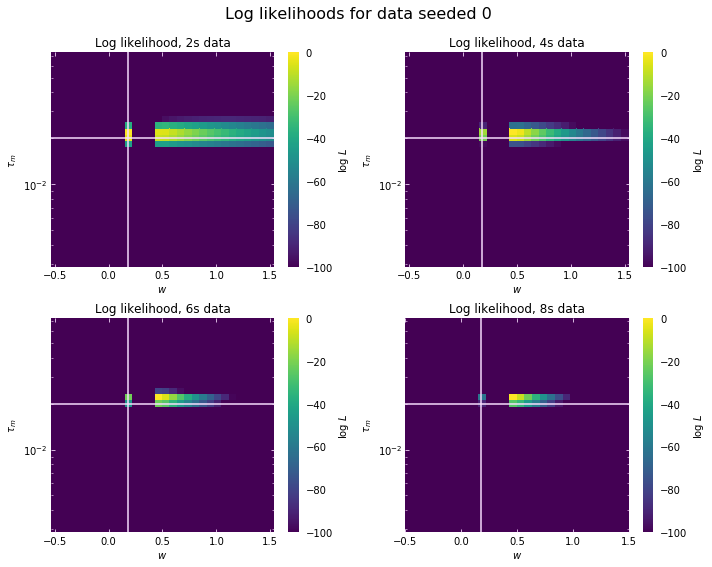

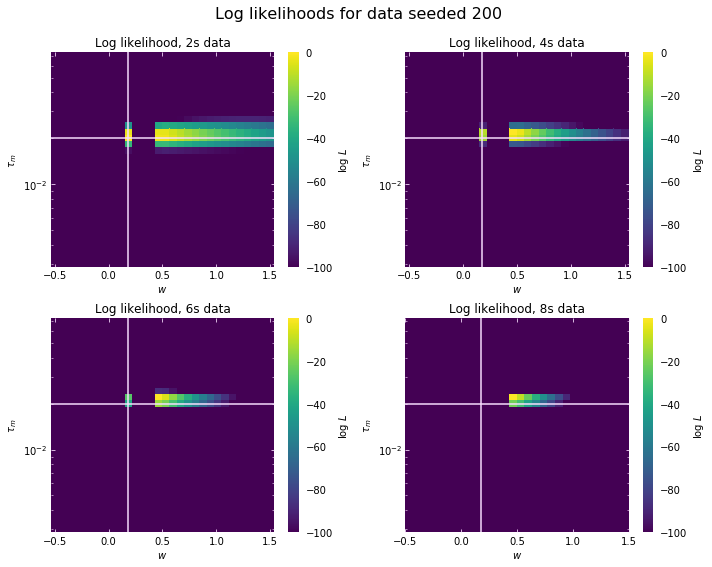

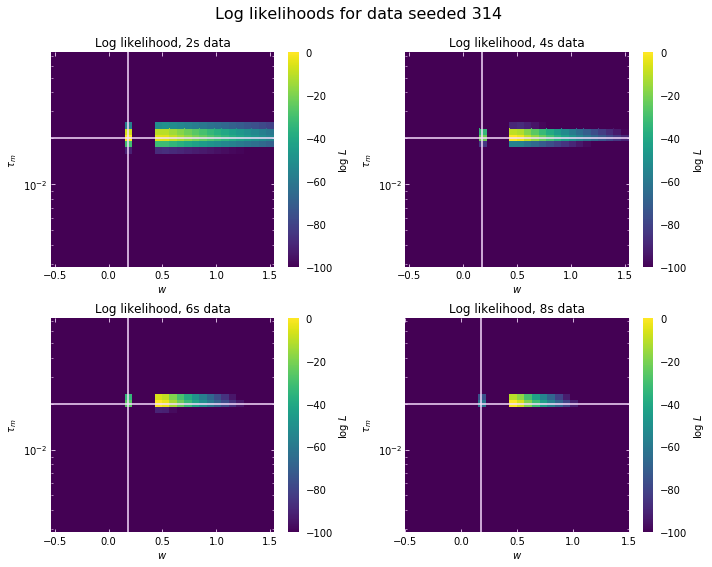

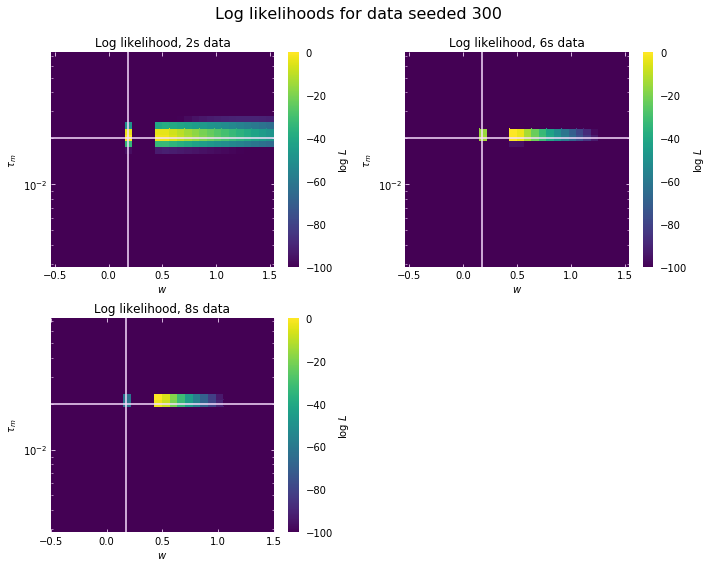

In [23]:
for seed, datalens in plot_datalens.items():
    plot_L(datalens,
           basedir + "fsgif_sin-input_{}s_" + str(seed) + "seed_loglikelihood_theano.sir",
           'log L',
           "Log likelihood, {}s data")
    plt.suptitle("Log likelihoods for data seeded {}".format(seed), fontsize=16)
    plt.xlim((-0.5,1.5))
    plt.subplots_adjust(top=0.9)

## Sliding 5ms window

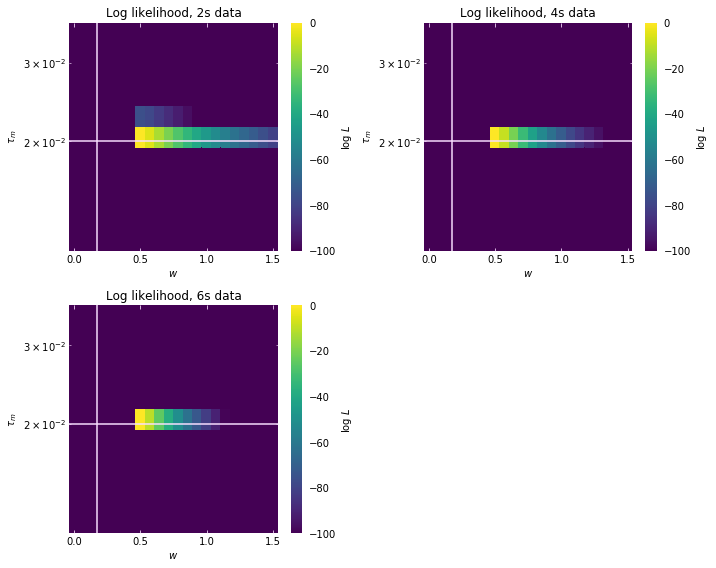

In [30]:
for seed in [314]:
    datalens = [2, 4, 6]
    plot_L(datalens,
           basedir + "fsgif_sin-input_{}s_" + str(seed) 
             + "seed_loglikelihood_5windowed_numpy.sir",
           'log L',
           "Log likelihood, {}s data")

## White noise input

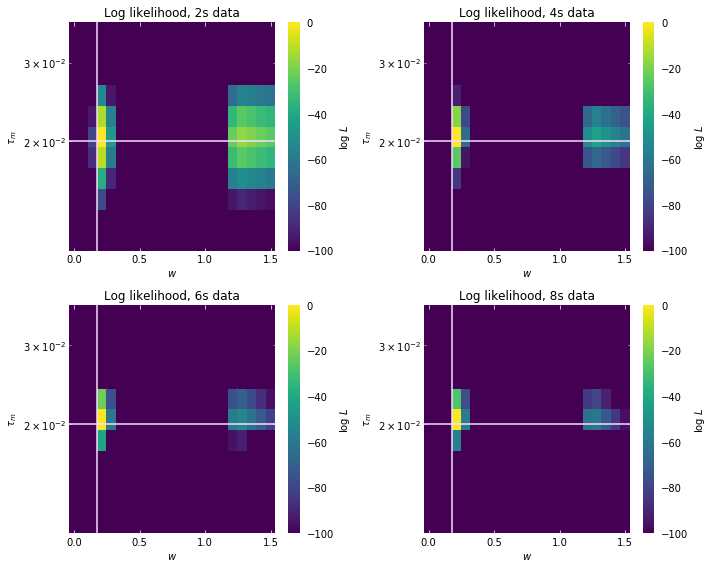

In [26]:
for seed in [314]:
    datalens = [2,4,6,8]
    plot_L(datalens,
           basedir + "fsgif_flat-input_{}s_" + str(seed)
            + "seed_loglikelihood_theano.sir",
           'log L',
           "Log likelihood, {}s data")

# No input

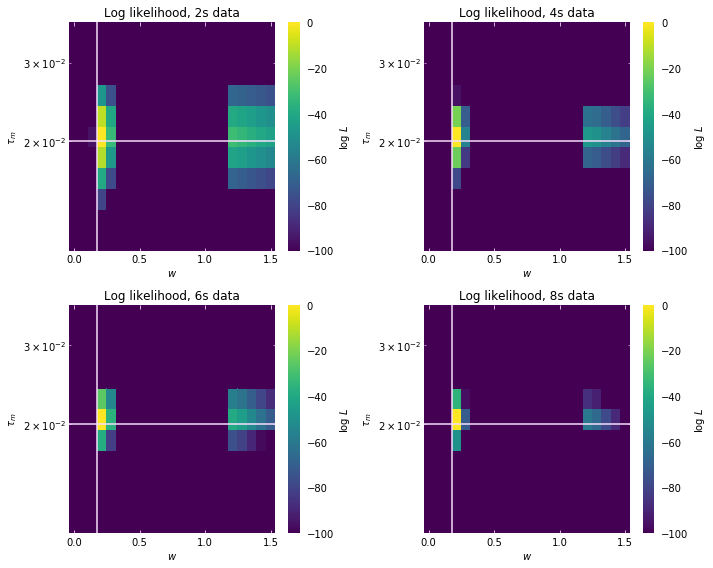

In [27]:
for seed in [314]:
    datalens = [2,4,6,8]
    plot_L(datalens,
           basedir + "fsgif_no-input_{}s_" + str(seed)
            + "seed_loglikelihood_theano.sir",
           'log L',
           "Log likelihood, {}s data")

# 1 population

## No input

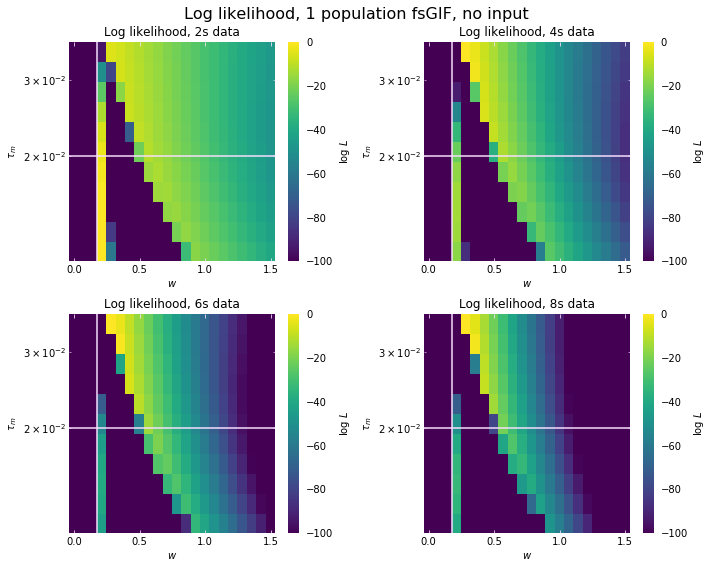

In [13]:
for seed in [314]:
    datalens = [2,4,6,8]
    plot_L(datalens,
           basedir + "fsgif_1pop_no-input_{}s_" + str(seed)
            + "seed_loglikelihood_theano.sir",
           'log L',
           "Log likelihood, {}s data")
    
    plt.suptitle("Log likelihood, 1 population fsGIF, no input", fontsize=16)
    
plt.subplots_adjust(top=0.92)

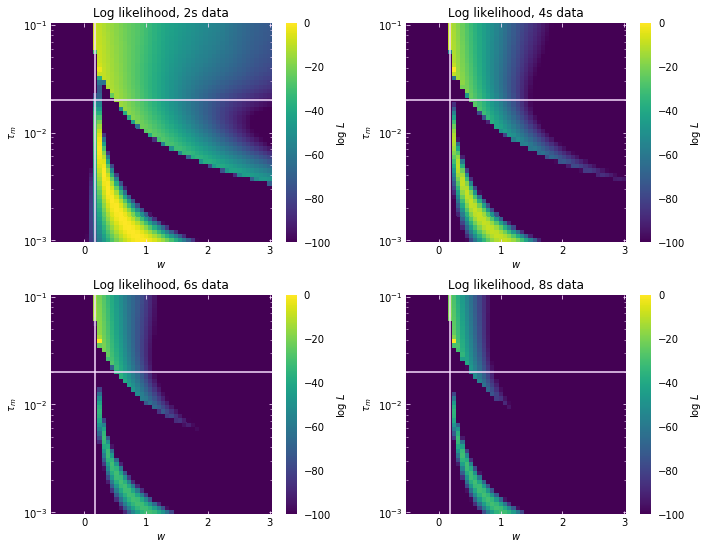

In [17]:
for seed in [314]:
    datalens = [2,4,6,8]
    plot_L(datalens,
           basedir + "fsgif_1pop_no-input_{}s_" + str(seed)
            + "seed_loglikelihood_theano_2.sir",
           'log L',
           "Log likelihood, {}s data")
    
    #plt.suptitle("Log likelihood, 1 population fsGIF, no input", fontsize=16)
    
plt.subplots_adjust(top=0.92)

# Exploration

In [24]:
mfmodel

NameError: name 'mfmodel' is not defined

In [7]:
logLs = []
for seed in [0, 200, 314]:
    logLs.append( heatmap.HeatMap.from_raw(io.loadraw(basedir + "fsgif_sin-input_4s_{}seed_loglikelihood_theano.sir".format(seed))) )

(0.012, 0.035)

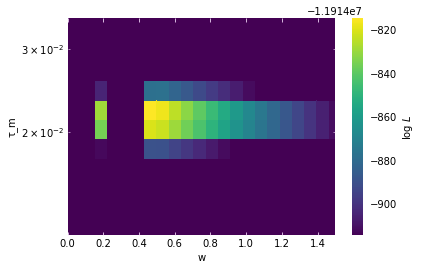

In [16]:
anlz.plot(logLs[0])
plt.xlim((0., 1.5))
plt.ylim((0.012, 0.035))

In [9]:
for i, seed in enumerate([0, 314]):
    logLs[i].set_floor(logLs[i].max() - 100)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f00a7a02080>,
 <matplotlib.colorbar.Colorbar at 0x7f00a3b3bfd0>)

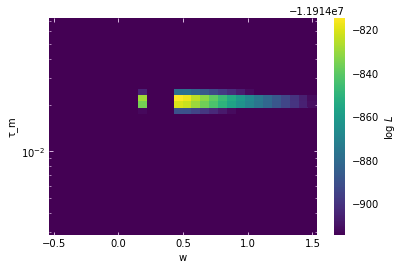

In [16]:

anlz.plot(logLs[0])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f00eba1a208>,
 <matplotlib.colorbar.Colorbar at 0x7f00a3dd60f0>)

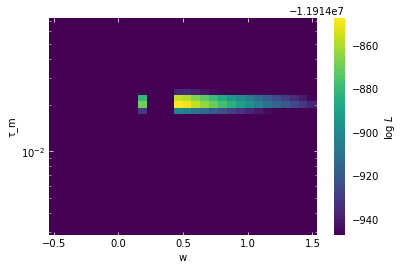

In [17]:
anlz.plot(logLs[1])

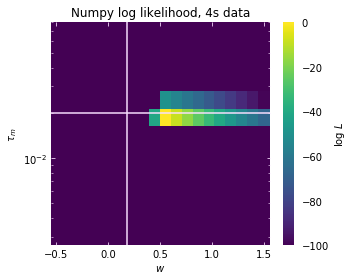

In [42]:
plot_L([4],
      basedir + "fsgif_{}s_sin-input_loglikelihood_numpy_corrected.sir",
      'log L',
      "Numpy log likelihood, {}s data")

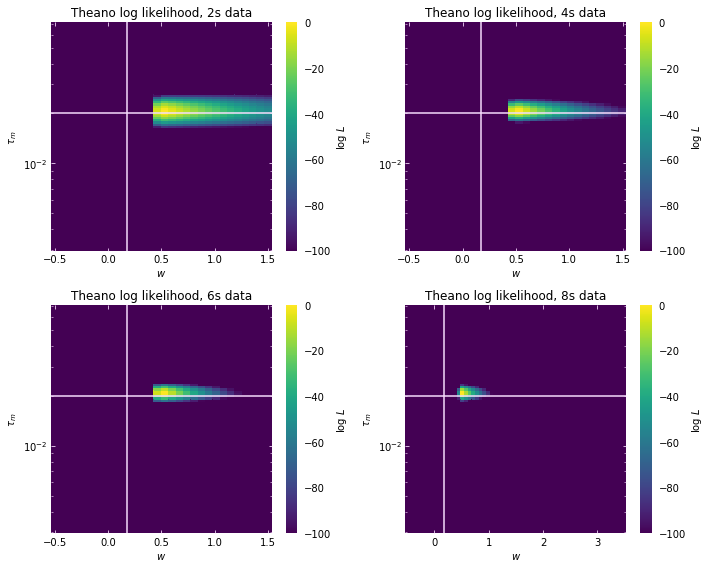

In [44]:
plot_L([2,4,6,8],
      basedir + "fsgif_sin-input_{}s_likelihood_theano.sir",
      'log L',
      "Theano log likelihood, {}s data")

In [7]:
logLT = heatmap.HeatMap.from_raw(io.loadraw(basedir + "fsgif_sin-input_8s_likelihood_theano.sir"))

In [8]:
logLT.set_floor(logLT.max() - 100)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc3d6dc2080>,
 <matplotlib.colorbar.Colorbar at 0x7fc3d6a46390>)

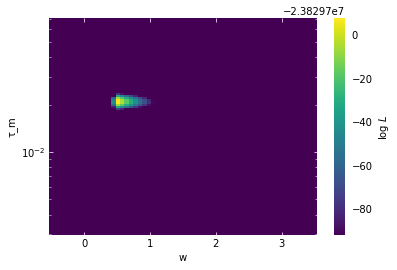

In [9]:
anlz.plot(logLT)

In [14]:
logL.argmax()

(0.46551724137931028, 0.020239421468008372)

In [21]:
logL = heatmap.HeatMap.from_raw(io.loadraw("fsgif_4s_sin-input_loglikelihood_numpy_corrected.sir"))

In [22]:
logL.set_floor(logL.max()-100)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5464a9fba8>,
 <matplotlib.colorbar.Colorbar at 0x7f546118bdd8>)

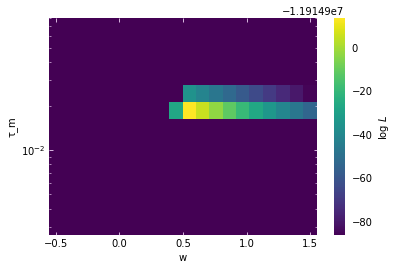

In [23]:
anlz.plot(logL)

In [24]:
logL.argmax()

(0.55263157894736836, 0.018841163261325577)